In [1]:
import numpy as np
import xarray as xr

In [2]:
folder = "/home/amir/Projects/Python/Atmpy/atmpy/output_data/traveling_vortex/"
suffix = "/_traveling_vortex_"
sizes = ["8_8.nc", "16_16.nc", "32_32.nc", "64_64.nc", "128_128.nc"]
axis = [8,]

In [3]:
data_var = "Y"
l2_values = []
l_inf_values = []
for size in sizes:
    path = folder + suffix + size
    ds = xr.open_dataset(path)
    initial = ds[data_var].isel(time=0).data
    final = ds[data_var].isel(time=-1).data
    diff = initial - final
    l2 = np.sqrt(np.mean(diff**2))
    l_inf = np.max(np.abs(diff))
    l2_values.append(l2)
    l_inf_values.append(l_inf)

/tmp/ipykernel_4975/3115248905.py:6: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(path)
/tmp/ipykernel_4975/3115248905.py:6: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(path)
/tmp/ipykernel_4975/3115248905.py:6: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(path)
/tmp/ipykernel_4975/3115248905.py:6: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'C

In [4]:
l2_values

[0.12012563614652866,
 0.08496413547083523,
 0.03699514940707983,
 0.018010265834616544,
 0.017051024305917317]

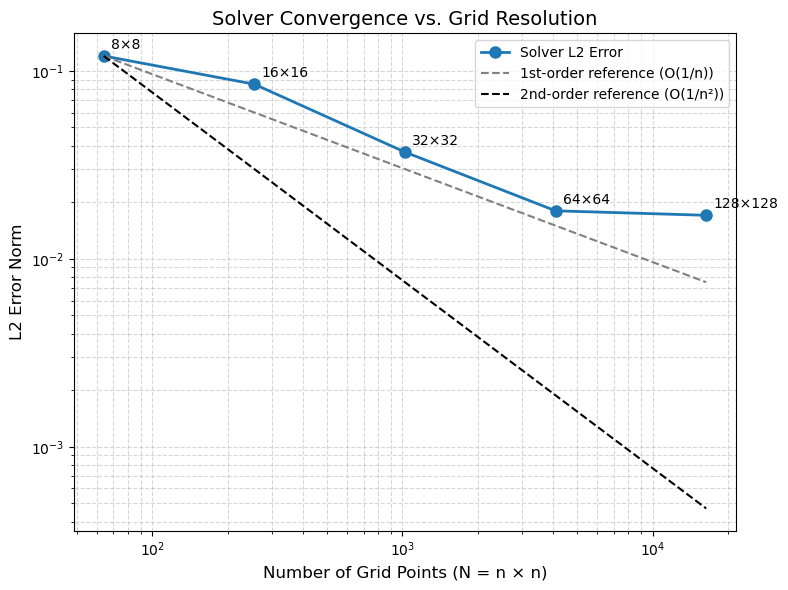

In [5]:
import matplotlib.pyplot as plt

# Your data (replace with actual values)
n_values = np.array([8, 16, 32, 64, 128])  # Grid points along one dimension (n x n grids)
l2_errors = l2_values  # Example L2 errors

# Compute total grid points (N = n × n)
N_values = n_values ** 2

# Reference lines (scaled to match the first data point)
ref_N1 = (1 / n_values) * (l2_errors[0] / (1 / n_values[0]))  # 1st-order (O(1/n))
ref_N2 = (1 / n_values**2) * (l2_errors[0] / (1 / n_values[0]**2))  # 2nd-order (O(1/n²))

# Plot
plt.figure(figsize=(8, 6))
plt.loglog(N_values, l2_errors, 'o-', label='Solver L2 Error', markersize=8, linewidth=2)
plt.loglog(N_values, ref_N1, '--', label='1st-order reference (O(1/n))', color='gray')
plt.loglog(N_values, ref_N2, '--', label='2nd-order reference (O(1/n²))', color='black')

# Labels and title
plt.xlabel('Number of Grid Points (N = n × n)', fontsize=12)
plt.ylabel('L2 Error Norm', fontsize=12)
plt.title('Solver Convergence vs. Grid Resolution', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, which="both", ls="--", alpha=0.5)

# Annotate grid sizes (e.g., "8×8", "16×16", etc.)
for i, n in enumerate(n_values):
    plt.annotate(f"{n}×{n}", (N_values[i], l2_errors[i]),
                 textcoords="offset points", xytext=(5,5), ha='left')

plt.tight_layout()
plt.show()
